## Dataset
Dowload dataset from [here](https://fred.stlouisfed.org/series/IPN31152n). 

In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

Saving IPN31152N.csv to IPN31152N.csv
User uploaded file "IPN31152N.csv" with length 11349 bytes


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [0]:
df = pd.read_csv('./IPN31152N.csv')

In [0]:
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [0]:
df['DATE'] = pd.to_datetime(df["DATE"])
df.set_index('DATE', inplace=True)
df.columns = ['sales']
df

,sales
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-10-01,90.1684
2019-11-01,79.7223
2019-12-01,75.7094


In [0]:
df.describe()

,sales
count,578.000000
mean,109.679526
std,27.932307
min,58.659800
25%,88.607775
50%,107.418250
75%,127.928775
max,196.173700


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 578 entries, 1972-01-01 to 2020-02-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   578 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [0]:
px.line(x=df.index.values, y=df['sales'])

In [0]:
tts_indx = 24
train = df.iloc[:-24]
test = df.iloc[-24:]

In [0]:
train

,sales
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2017-10-01,90.4732
2017-11-01,77.4378
2017-12-01,75.8118


In [0]:
test

,sales
DATE,
2018-03-01,107.3152
2018-04-01,112.4309
2018-05-01,110.3544
2018-06-01,124.5841
2018-07-01,117.2215
2018-08-01,112.6779
2018-09-01,103.3118
2018-10-01,92.1321
2018-11-01,82.4347


In [0]:
from sklearn.preprocessing import MinMaxScaler 

In [0]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [0]:
max(scaled_train)

array([1.])

In [0]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
length = 18
generator = TimeseriesGenerator(scaled_train, scaled_train, length=12, batch_size=1)
val_generator = TimeseriesGenerator(scaled_test, scaled_test, length=12, batch_size=1)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
early_stop = EarlyStopping('val_loss', patience=2)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN

In [0]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [0]:
model.fit_generator(generator, epochs=20, validation_data=val_generator)

Epoch 1/20
542/542 [==============================] - 3s 5ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 2/20
542/542 [==============================] - 3s 5ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 3/20
542/542 [==============================] - 3s 5ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 4/20
542/542 [==============================] - 3s 5ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 5/20
542/542 [==============================] - 3s 5ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 6/20
542/542 [==============================] - 3s 5ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 7/20
542/542 [==============================] - 3s 5ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 8/20
542/542 [==============================] - 3s 5ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 9/20
542/542 [==============================] - 3s 5ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 10/20
542/542 [==============================] - 3s 5ms/step - loss: 0.0026 - val_loss: 0.0017

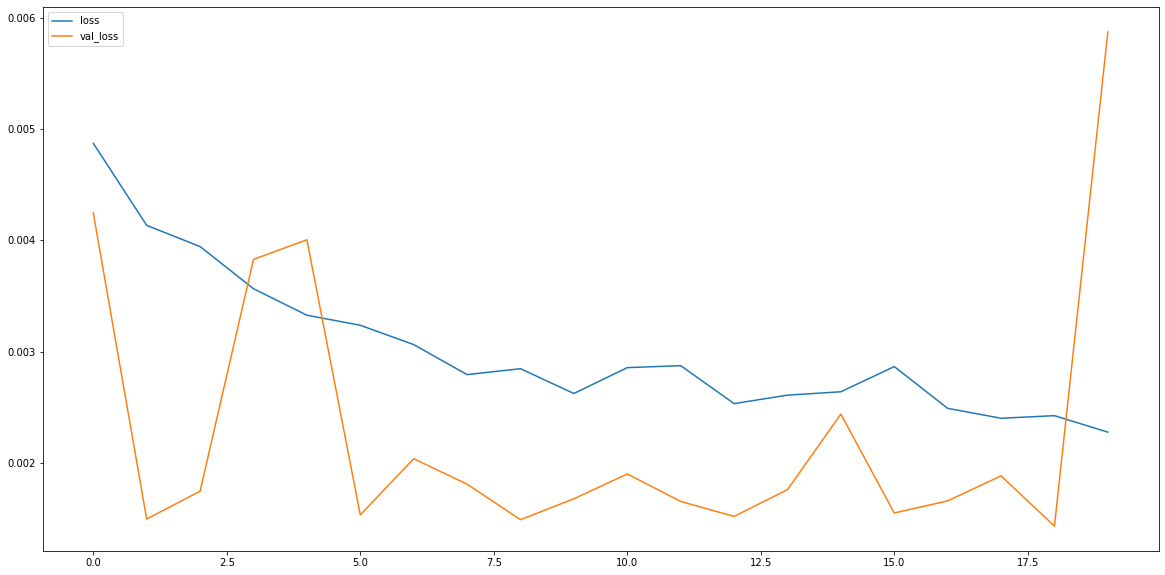

In [0]:
pd.DataFrame(model.history.history).plot(figsize=[20,10])

In [0]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1,length,1))

In [0]:
predictions = []
curr_batch = first_eval_batch
for i in range(len(test)):
  curr_pred = model.predict(curr_batch)[0]
  curr_batch = curr_batch[:,1:,:]
  curr_batch = np.append(curr_batch,[[curr_pred]], axis=1)
  predictions.append(curr_pred)

In [0]:
predictions = scaler.inverse_transform(predictions)

In [0]:
predictions

array([[111.62253072],
       [120.71570778],
       [126.98553386],
       [131.16695339],
       [133.00016704],
       [131.70883003],
       [125.81945117],
       [115.65315574],
       [104.12398454],
       [ 97.42604059],
       [101.08318129],
       [112.74678684],
       [123.96441033],
       [133.02683834],
       [138.32480521],
       [140.68613363],
       [138.20167788],
       [131.13843788],
       [120.55800775],
       [108.57162942],
       [100.28228809],
       [102.71539297],
       [115.10112778],
       [127.82911426]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



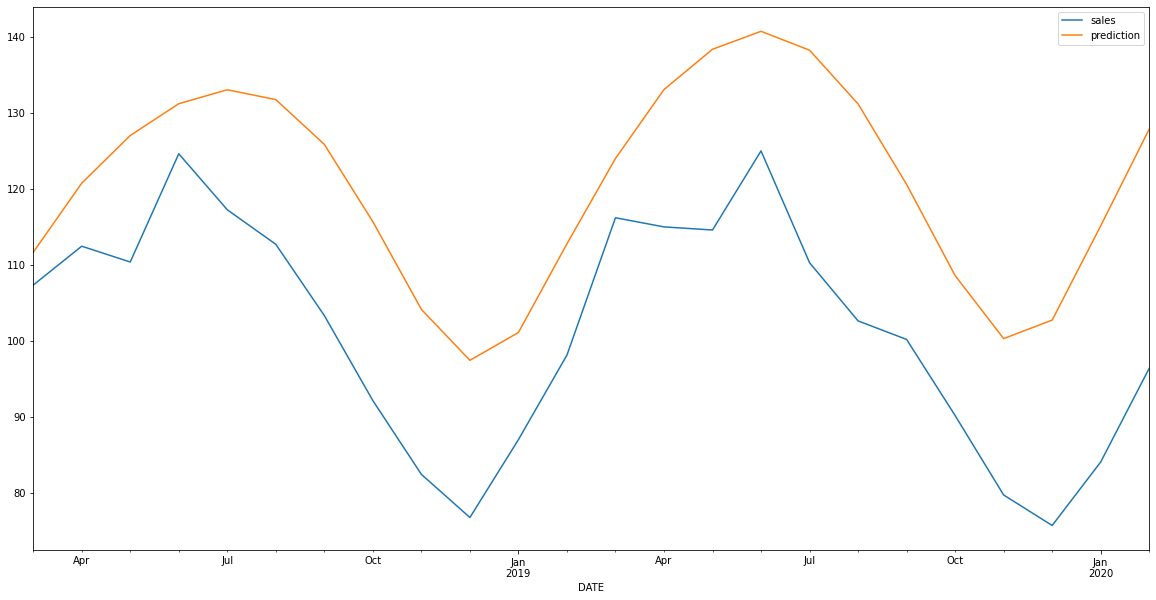

In [0]:
test['prediction'] = predictions
test.plot(figsize=[20,10])

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
np.sqrt(mean_squared_error(test['sales'], test['prediction']))

20.454012442590333

In [0]:
full_scaler = MinMaxScaler()
scaled_data = full_scaler.fit_transform(df)

In [0]:
generator = TimeseriesGenerator(scaled_data, scaled_data, length, batch_size=1)

In [0]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [0]:
model.fit_generator(generator, epochs=4)

Epoch 1/4
564/564 [==============================] - 3s 6ms/step - loss: 0.0229
Epoch 2/4
564/564 [==============================] - 4s 6ms/step - loss: 0.0111
Epoch 3/4
564/564 [==============================] - 4s 6ms/step - loss: 0.0067
Epoch 4/4
564/564 [==============================] - 4s 6ms/step - loss: 0.0050


In [0]:
first_eval_batch = scaled_data[-length:]
first_eval_batch = first_eval_batch.reshape((1,length,1))

In [0]:
forecast = []
curr_batch = first_eval_batch
for i in range(24):
  curr_pred = model.predict(curr_batch)[0]
  curr_batch = curr_batch[:,1:,:]
  curr_batch = np.append(curr_batch,[[curr_pred]], axis=1)
  forecast.append(curr_pred)

In [0]:
forecast = scaler.inverse_transform(forecast)

In [0]:
forecaste_index = pd.date_range(start='2020-03-01', periods=24, freq='MS')
forecaste_index

DatetimeIndex(['2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01'],
              dtype='datetime64[ns]', freq='MS')

In [0]:
forecaste_df = pd.DataFrame(forecast, index=forecaste_index, columns=['Forecast'])

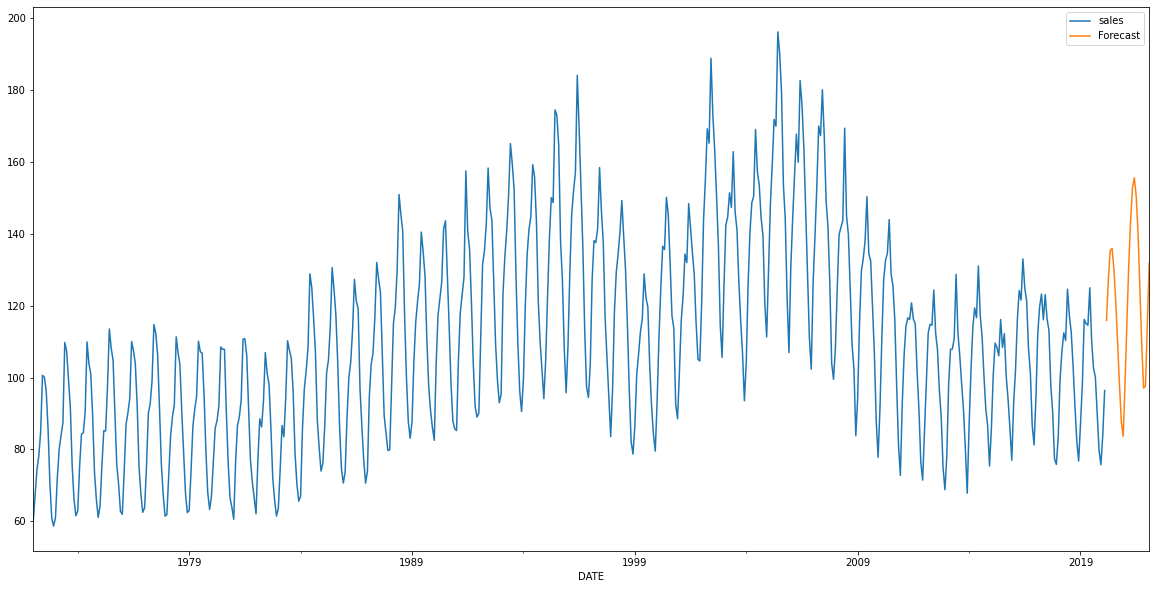

In [0]:
ax = df.plot()
forecaste_df.plot(ax=ax, figsize=[20,10])